In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc

In [2]:
pc.config.cloudy_exe = 'cloudy.exe'

In [10]:
# Create the directory 
models_dir = "../../SIGNALS_Models"
try: 
    os.makedirs(models_dir)
except OSError:
    if not os.path.isdir(models_dir):
        raise

In [12]:
pc.print_make_file(models_dir)

In [36]:
name = 'M1'
c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = 48)
c_input.set_cste_density(2., ff = 1.)
c_input.set_radius(r_in = 15.)
c_input.set_abund(predef = 'ism')
c_input.set_distance(dist=1., unit='kpc', linear=True)
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
c_input.set_other(options)
c_input.print_input()

In [37]:
!cat ../../SIGNALS_Models/M1.in

////////////////////////////////////
title M1
////////////////////////////////////
set punch prefix "M1"
Blackbody 50000.000000
q(H) = 48.000
radius = 15.000
hden = 2.000
filling factor = 1.000000
abundances ism no grains
distance = 1000.0 parsecs linear
no molecules
no level2 lines
no fine opacities
atom h-like levels small
atom he-like levels small
element limit off -7
save last radius ".rad"
save last continuum ".cont"
save last physical conditions ".phy"
save last overview ".ovr"
save last heating ".heat"
save last cooling ".cool"
save last optical depth ".opd"
save last element hydrogen ".ele_H"
save last element helium ".ele_He"
save last element carbon ".ele_C"
save last element nitrogen ".ele_N"
save last element oxygen ".ele_O"
save last element argon ".ele_Ar"
save last element neon ".ele_Ne"
save last element sulphur ".ele_S"
save last element chlorin ".ele_Cl"
save last element iron ".ele_Fe"
save last element silicon ".ele_Si"


In [16]:
c_input.run_cloudy()

In [17]:
pc.log_.level=3
M1 = pc.CloudyModel('{0}/{1}'.format(models_dir, name))
# A warning is issued because no emission line file is found. 
# This is a normal behaviour, we didn't set it.

     CloudyModel ../../SIGNALS_Models/M6_1: Creating CloudyModel for ../../SIGNALS_Models/M6_1
     CloudyModel ../../SIGNALS_Models/M6_1: Li abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Be abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: B abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: F abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Al abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: K abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Ca abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Sc abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Ti abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: V abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Cr abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Mn abundance not defined
     CloudyModel ../../SIGNALS_Models/M6_1: Co abundance not defined
     CloudyM

In [18]:
M1.print_stats()

 Name of the model: ../../SIGNALS_Models/M6_1
 R_in (cut) = 1.000e+15 (1.000e+15), R_out (cut) = 4.003e+18 (4.003e+18)
 H+ mass = 2.06e+01, H mass = 2.26e+01 N zones: 321
 <H+/H> = 0.97, <He++/He> = 0.00, <He+/He> = 0.97
 <O+++/O> = 0.00, <O++/O> = 0.57, <O+/O> = 0.40
 <N+++/O> = 0.01, <N++/O> = 0.64, <N+/O> = 0.33
 T(O+++) = 7055, T(O++) = 6565, T(O+) = 7746
 <ne> = 100,  <nH> = 100, T0 = 7097, t2=0.0204
 <log U> = -2.30


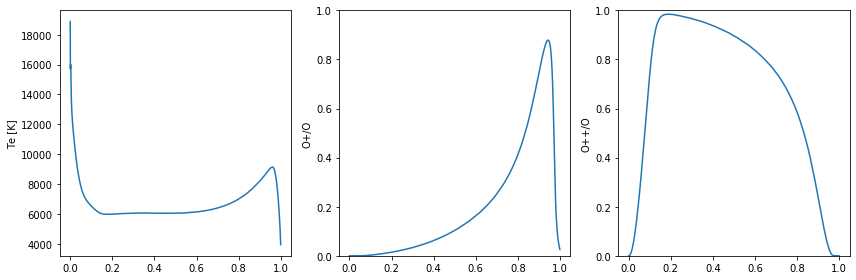

In [20]:
f, axes = plt.subplots(1, 3, figsize=(12,4))
x = M1.depth/np.max(M1.depth)
axes[0].plot(x, M1.te)
axes[0].set_ylabel('Te [K]')
axes[1].plot(x, M1.get_ionic('O', 1))
axes[1].set_ylabel('O+/O')
axes[1].set_ylim(0,1)
axes[2].plot(x, M1.get_ionic('O', 2))
axes[2].set_ylabel('O++/O')
axes[2].set_ylim(0,1)
f.tight_layout()

In [38]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
from pyCloudy.utils.physics import abund_Asplund_2009

def get_R_in_Q0(logU, fr, NH=100, ff=1.0):
    c = pc.CST.CLIGHT
    U_mean = 10**logU
    w = (1 + fr**3.)**(1./3) - fr
    alpha_B = 2.6e-13
    Q0 = 4. * np.pi * c**3 * U_mean**3 / (3. * NH * ff**2 * alpha_B**2 * w**3)
    R_str = (3. * Q0 / (4 * np.pi * NH**2 * alpha_B * ff))**(1./3)
    R_in = fr * R_str
    return R_in, Q0

def make_mod(name, logU, ab_O):
    NH = 100
    ff = 0.1
    fr = 3.00
    R_in, Q0 = get_R_in_Q0(logU, fr=fr, NH=NH, ff=ff)
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = np.log10(Q0))
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_radius(r_in = np.log10(R_in))
    abund = abund_Asplund_2009.copy()
    delta_O = ab_O - 12 - abund['O']
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    c_input.set_abund(ab_dict = abund)
    #c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.set_emis_tab(['H  1  4861.33A', 'H  1  6562.81A', 
                          'N  2  6583.45A', 'O  3  5006.84A'])
    c_input.print_input()

In [39]:
generic_name = 'M2_'

In [40]:
for logU in np.arange(-3.5, -1.49, 0.5):
    for ab_O in np.arange(7, 9.1, 0.5):
        name = '{}{:.1f}_{:.1f}'.format(generic_name, logU, ab_O)
        make_mod(name, logU, ab_O)

In [41]:
pc.run_cloudy(dir_=models_dir, n_proc=8, model_name=generic_name)

In [44]:
pc.log_.level=2
Ms = pc.load_models('{}/{}'.format(models_dir, generic_name))
M = Ms[0]

In [48]:
x = np.array([M.log_U_mean for M in Ms])
logHb = np.log10(np.array([M.get_emis_vol('H__1_486133A') for M in Ms]))
logQ = np.log10(np.array([M.Q.sum() for M in Ms]))
y = logHb - logQ
c = 12+np.array([M.abund['O'] for M in Ms])

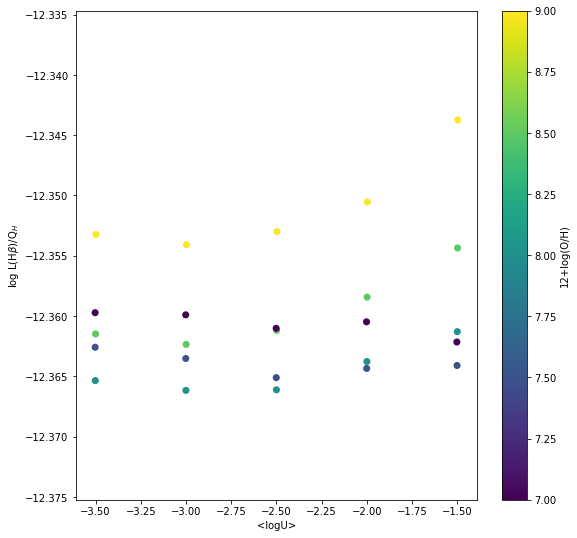

In [49]:
f, ax = plt.subplots(figsize=(9, 9))
sc = ax.scatter(x, y, c=c, edgecolor='none', s=50)
ax.set_xlabel('<logU>')
ax.set_ylabel(r'log L(H$\beta$)/Q$_ H$')
cb = f.colorbar(sc)
cb.set_label(r'12+log(O/H)')

In [50]:
from pyCloudy.utils.astro import conv_arc

In [51]:
# Define some parameters of the model:
model_name = 'model_4'
full_model_name = '{0}/{1}'.format(models_dir, model_name)
dens = 4. #log cm-3
Teff = 45000. #K
qH = 47. #s-1
r_min = 5e16 #cm
dist = 1.26 #kpc
# these are the commands common to all the models (here only one ...)
options = ('no molecules',
            'COSMIC RAY BACKGROUND',
            )
emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A']
abund = {'He' : -0.92, 'C' : 6.85 - 12, 'N' : -4.0, 'O' : -3.40, 'Ne' : -4.00, 
         'S' : -5.35, 'Ar' : -5.80, 'Fe' : -7.4, 'Cl' : -7.00}
c_input = pc.CloudyInput(full_model_name)
c_input.set_BB(Teff = Teff, lumi_unit = 'q(H)', lumi_value = qH)
c_input.set_cste_density(dens)
# Defining the inner radius. A second parameter would be the outer radius (matter-bounded nebula).
c_input.set_radius(r_in=np.log10(r_min))
c_input.set_abund(ab_dict = abund, nograins = True)
c_input.set_other(options)
c_input.set_iterate() # (0) for no iteration, () for one iteration, (N) for N iterations.
c_input.set_sphere() # () or (True) : closed geometry, or (False): open geometry.
c_input.set_emis_tab(emis_tab) # better use read_emis_file(file) for long list of lines, where file is an external file.
c_input.set_distance(dist=dist, unit='kpc', linear=True) # unit can be 'kpc', 'Mpc', 'parsecs', 'cm'. If linear=False, the distance is in log.
c_input.print_input(to_file = True, verbose = False)


In [52]:
# Running Cloudy with a timer. Here we reset it to 0.
pc.log_.timer('Starting Cloudy', quiet = True, calling = 'test1')
c_input.run_cloudy()
pc.log_.timer('Cloudy ended after seconds:', calling = 'test1')

   test1: Cloudy ended after seconds: in 41.68274998664856


In [53]:
c_output = pc.CloudyModel(full_model_name)
c_output.print_stats()

 Name of the model: ../../SIGNALS_Models/model_4
 R_in (cut) = 5.000e+16 (5.000e+16), R_out (cut) = 9.546e+16 (9.546e+16)
 H+ mass = 2.57e-02, H mass = 2.63e-02 N zones: 157
 <H+/H> = 0.99, <He++/He> = 0.00, <He+/He> = 0.89
 <O+++/O> = 0.00, <O++/O> = 0.56, <O+/O> = 0.42
 <N+++/O> = 0.01, <N++/O> = 0.66, <N+/O> = 0.33
 T(O+++) = 8929, T(O++) = 8591, T(O+) = 9077
 <ne> = 10844,  <nH> = 10000, T0 = 8802, t2=0.0024
 <log U> = -2.31


In [54]:
# define the size of the 3D cube and instanciate the object that manage it.
cube_size = 201
M_sphere = pc.C3D(c_output, dims=cube_size, center=True, n_dim=1)

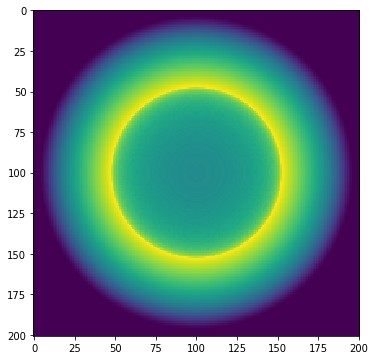

In [63]:
# plot the image of the OIII emission
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(M_sphere.get_emis('O__3_500684A').sum(0));

In [58]:
arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)

In [59]:
def make_mask(ap_center=[0., 0.], ap_size=[1., 1.]):
    """
    This returns a mask (values between 0. and 1.) to be multiplied to the image to take the flux passing through an aperture.
    An pc.C3D object named M_sphere must exist outside theis function
    """
    x_arc = arcsec(M_sphere.cub_coord.x_vec)
    y_arc = arcsec(M_sphere.cub_coord.y_vec)
    z_arc = arcsec(M_sphere.cub_coord.z_vec)
    X, Y = np.meshgrid(y_arc, x_arc)
    bool_mask = ((X > ap_center[0] - ap_size[0]/2.) & 
            (X <= ap_center[0] + ap_size[0]/2.) & 
            (Y > ap_center[1] - ap_size[1]/2.) & 
            (Y <= ap_center[1] + ap_size[1]/2.))
    mask = np.zeros_like(X)
    mask[bool_mask] = 1.0
    return mask

In [60]:
# we define the mask. Can be change to see the effect of the aperture on line intensities
mask = make_mask(ap_center=[1.5, 2.3], ap_size=[50, 1.5])

In [61]:
# Check that the mask is not empty
print(mask.size)
print(mask.sum())

40401
6030.0


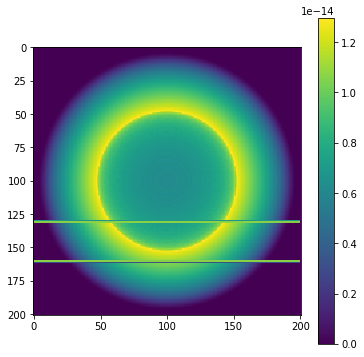

In [67]:
# We plot the OIII image and overplot the mask.
f, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(M_sphere.get_emis('O__3_500684A').sum(0), interpolation='None')
f.colorbar(im, ax=ax)
ax.contour(mask);

In [69]:
# Hbeta is computed for the whole object and throught the aperture
Hb_tot = (M_sphere.get_emis('H__1_486133A')*M_sphere.cub_coord.cell_size).sum()
Hb_slit = ((M_sphere.get_emis('H__1_486133A')*M_sphere.cub_coord.cell_size).sum(1) * mask).sum()
print('{:.3e} {:.3e}'.format(Hb_tot, Hb_slit))

4.664e+34 8.855e+33


In [70]:
# For every line, we compute the intensity for the whole object and throught the aperture.
# We also print out the difference due to the slit.
for label in M_sphere.m[0].emis_labels:
    I_tot = (M_sphere.get_emis(label).sum()*M_sphere.cub_coord.cell_size) / Hb_tot
    I_slit = ((M_sphere.get_emis(label).sum(1) * mask).sum()*M_sphere.cub_coord.cell_size) / Hb_slit
    print('line: {0:12s} I/Ib Total: {1:6.4f} I/Ib Slit: {2:6.4f} Delta: {3:4.1f}%'.format(label, I_tot, I_slit, 
                                                                                           (I_slit-I_tot)/I_tot*100))

line: H__1_486133A I/Ib Total: 1.0000 I/Ib Slit: 1.0000 Delta:  0.0%
line: H__1_656281A I/Ib Total: 2.7962 I/Ib Slit: 2.7964 Delta:  0.0%
line: CA_B_587564A I/Ib Total: 0.1645 I/Ib Slit: 0.1676 Delta:  1.8%
line: N__2_658345A I/Ib Total: 1.1132 I/Ib Slit: 0.9670 Delta: -13.1%
line: O__1_630030A I/Ib Total: 0.0151 I/Ib Slit: 0.0123 Delta: -19.1%
line: O__2_372603A I/Ib Total: 0.7818 I/Ib Slit: 0.6911 Delta: -11.6%
line: O__2_372881A I/Ib Total: 0.3481 I/Ib Slit: 0.3075 Delta: -11.7%
line: O__3_500684A I/Ib Total: 3.7746 I/Ib Slit: 3.9979 Delta:  5.9%
line: BLND_436300A I/Ib Total: 0.0153 I/Ib Slit: 0.0161 Delta:  5.1%
